In [350]:
import pandas as pd
import numpy as np
import cloudpickle
import sklearn
df=pd.read_csv("../../assets/assignment/df_train.csv.gz")
events=df['event.id'].unique()

## EDA

##### Looking at the relationship between ranking and price. We might expect price to hold predictive power - it was quite surprising that the integration of price led to poorer holdout scores. 

##### You ran a similar analysis between age and ranking during office hours. This was also a rather surprising trend. It's possible that we need additional features when incorporating age and ranking into our model, such as resting heart rate, body fat percentage, or other fitness indicators.

In [326]:
import seaborn as sns
import matplotlib.pyplot as plt

df_viz = df.copy()

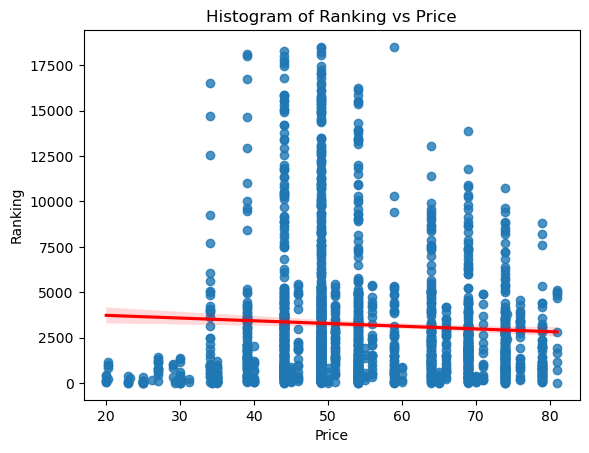

In [327]:


sns.regplot(x='price', y='overall_ranking', data=df_viz[df_viz['price'] > 0].sample(2000), line_kws={'color': 'red'})

# Set plot title and labels
plt.title("Histogram of Ranking vs Price")
plt.xlabel("Price")
plt.ylabel("Ranking")

# Show the plot
plt.show()

##### We can see a strong difference in ranking distribution between male and female. Males tend to have lower 25%, median and 75% quartiles for overall ranking than women do. Women tend to have higher variation in ranking, as indicated by greater boxplot width.

##### I expect age to be a feature that holds tremendous predictive power in our model.

In [328]:
df_viz.loc[df_viz['sex'] == 'F', 'sex'] = 'Female'
df_viz.loc[df_viz['sex'] == 'M', 'sex'] = 'Male'
df_viz.loc[df_viz['sex'].str.lower().str.contains('specified', na = False), 'sex'] = np.nan

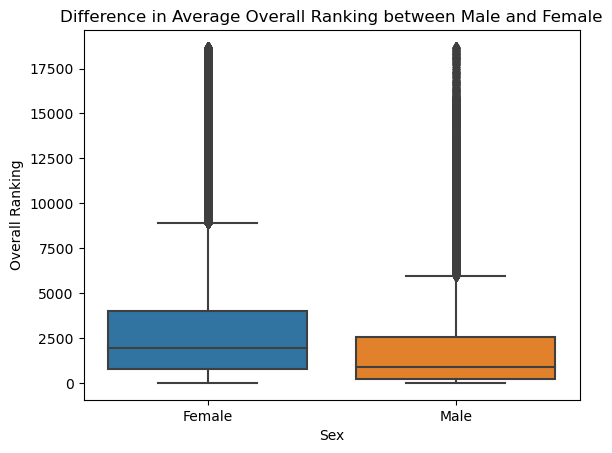

In [329]:
sns.boxplot(x="sex", y="overall_ranking", data=df_viz)

plt.title("Difference in Average Overall Ranking between Male and Female")
plt.xlabel("Sex")
plt.ylabel("Overall Ranking")
plt.show()

##### We can see a strong inverse relationship between the number of previous races a user participated in and their overall ranking.

In [330]:
previous_races_by_user = df_viz.groupby('user_id').count().iloc[:, -1].reset_index(name='num_previous_races')
df_viz = pd.merge(df_viz, previous_races_by_user, on='user_id', how='left')

<AxesSubplot: xlabel='num_previous_races', ylabel='overall_ranking'>

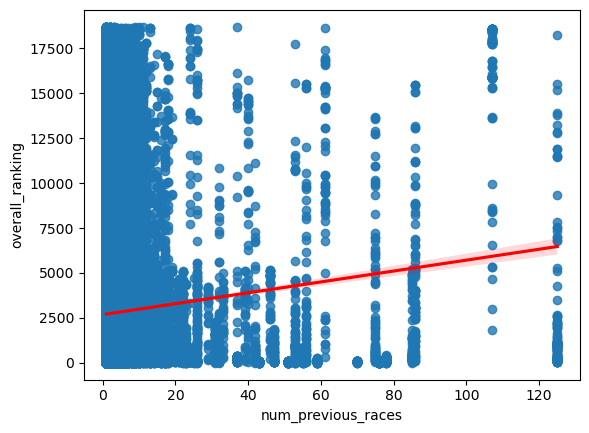

In [331]:
sns.regplot(x="num_previous_races", y="overall_ranking", data=df_viz, line_kws={'color': 'red'})

##### We can see some differences in distribution between the long and short distance runs, especially in terms of variance. It could be worth including in our model, but I don't expect it to be a major predictor.
##### The others formats have smaller sample sizes.

In [332]:
dict_short = {'long_distance_run': ['15k', 'marathon', 'half marathon', '10 mile run', '30k run'],
              #'long_distance_walk': ['half marathon walk', '15k walk']
              'short_distance_run': ['5k', '8k run', '10k run', '6k run']
              #'short_distance_walk': ['5k walk', '8k walk', '10k walk', '6k walk'],
              #'multi_sport': ['sprint triathlon', 'olympic triathlon', 'sprint duathlon', 'olympic duathlon', 'run swim run'],
              #'wheelchair': ['wheelchair 15k', 'wheelchair 5k']
             }

for category, values in dict_short.items():
    df_viz.loc[df_viz['clean_category.completed.name'].isin(values), 'type'] = category 
        
        

<AxesSubplot: xlabel='type', ylabel='overall_ranking'>

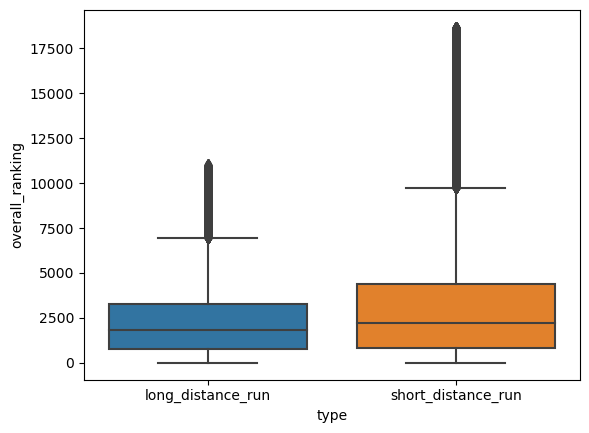

In [333]:
sns.boxplot(x="type", y="overall_ranking", data=df_viz)

## ML Pipeline

In [351]:
train_set=events[0:100]
test_set=events[100:200]
holdout_set=events[200:300]

In [352]:
train=df.query("`event.id` in @train_set")
validation =df.query("`event.id` in @test_set")
holdout=df.query("`event.id` in @holdout_set")

In [353]:
#dropping columns that would cause data leakage

holdout=holdout.drop(
    columns=['time.end',
             'body.results_certificate',
             'event.results_posted',
             'event.results_posted',
             'event.results_certificate',
             'event.photos_available',
             'event.photos_faces',
             'event.photos_social_sharing',
             'event.results_searchable',
             'corral.id',
             'corral.name',
             'corral.wave',
             'corral.time.close',
             'corral.time.start',
             'result.duration.chip',
             'result.duration.pace',
             'result.rankings',
             'result.splits',
             'result.videos',
             'result.finished',
             'result.disqualified',
             'result.duration'])

In [354]:
#making sure that we have 6 rows per race in our data
holdout=df.groupby(["event.id","clean_categories.name"]).filter(lambda z: len(z)>5)

In [355]:
#creating series for training target variables, and validation target variables. We will use the validation set 
#for hyperparameter fine tuning our random forest model below

y_train=pd.to_timedelta(train['result.duration.chip']).astype(int)
y_validation = pd.to_timedelta(validation['result.duration.chip']).astype(int)

In [356]:
### Autograder cell



holdout_data=holdout

# This is the scoring function to determine model fitness
def score(left: pd.DataFrame, right: pd.DataFrame):
    '''
    Calculates the difference between the left and the right when considering rank of items. 
    This scoring function requires that the two DataFrames have identical indicies, and that
    they each contain only one column of values and no missing values.
    '''
    assert(type(left)==pd.DataFrame)
    assert(type(right)==pd.DataFrame)
    assert(len(left)==len(right))
    assert(not np.any(np.isnan(left)))
    assert(not np.any(np.isnan(right)))
    assert(left.index.equals(right.index))
    # convert to ndarrays
    left=left.squeeze()
    right=right.squeeze()
    return np.sum(np.abs(left-right))/(len(left)*(len(left)-1))

# This function runs the prediction model agains a given event/category pair. It
# intentionally loads the student model each time to avoid accidental leakage of data
# between events.
def evaluate(data, pipeline_file='pipeline.cloudpickle'):
    # Load student pipeline
    fitted_pipe = cloudpickle.load(open(pipeline_file,'rb'))
    
    # Separate out the X and y
    X=list(set(data.columns)-{'overall_ranking'})
    y=['overall_ranking']
    
    # Drop any missing results (DNFs)
    data=data.dropna(subset=['overall_ranking'])
    
    # Ensure there is data to actually predict on
    if len(data)==0:
        return np.nan

    # Predict on unseen data
    from IPython.utils import io
    with io.capture_output() as captured:
        predictions=pd.DataFrame(fitted_pipe.predict(data[X]),data.index)
    observed=data[y]
    
    # Generate rankings within this bracket
    observed=pd.DataFrame(data[y].rank(),data.index)

    # Return the ratio of the student score
    return pd.Series({"score":score(observed,predictions)})

# Student solution
pipeline_file='pipeline.cloudpickle'

def autograde(data_held_out):
    # Run prediction on each group
    results=data_held_out.groupby(["event.id","clean_categories.name"]).apply(evaluate, pipeline_file)

    # Display the results, uncomment this for your own display
    results.reset_index()['score'].plot.bar();

    # This is the student final grade
    print(np.average(results))

In [363]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


# Defining our preprocessor classes below


#Preprocessing sex such that all the values are named by a consistent scheme. 
#Unspecified values are represented as nans
class SexPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X.loc[X['sex'] == 'F', 'sex'] = 'Female'
        X.loc[X['sex'] == 'M', 'sex'] = 'Male'
        X.loc[X['sex'].str.lower().str.contains('specified', na = False), 'sex'] = np.nan
        
        return X
    

#Creating a distance variable that measures how long each course is.
class DistPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.unit_to_km = {'km': 1.0, 'mi': 1.60934}
        return self
    
    def transform(self, X, y=None):
        X['distance'] = X['category.completed.distance.quantity'] * X['category.completed.distance.unit'].map(self.unit_to_km)
        
        return X

#creating a class that looks at the number of races a user ran, as a predictor for success.
class NumRacesPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        #grouping by user id and creating a new column that counts the number of total instances per user in the dataset.
        self.previous_races = X.groupby('user_id').count().iloc[:, -1].reset_index(name='num_previous_races')
        return self
    
    def transform(self, X):
        #merging this dataset with the broader dataset
        X = pd.merge(X, self.previous_races, on='user_id', how='left')
        return X
    
    
#a class that determines the number of prior incomplete races per user, as in indicator for success.
class IncompleteRacesPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        #creating an indicator that determines whether or not the user finished the race
        X['incomplete_race_boolean'] = np.where(X['category.registered.distance.quantity'] == X['category.completed.distance.quantity'], 0 , 1)
        
        #finding the number of races that were not completed per user
        self.incomplete_races = X[['user_id', 'incomplete_race_boolean']].groupby('user_id').sum().reset_index()
        
        #renaming indicator and merging with broader dataset.
        self.incomplete_races.rename(columns={'incomplete_race_boolean': 'incomplete_race'}, inplace=True)
        X = pd.merge(X, self.incomplete_races, on = 'user_id', how = 'left')
        
        return X

#one hot encoder for the type of race. Grouping names of events into broader categories.
class RaceTypeEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.categories = {
            'long_distance_run': ['15k', 'marathon', 'half marathon', '10 mile run', '30k run'],
            'long_distance_walk': ['half marathon walk', '15k walk'],
            'short_distance_run': ['5k', '8k run', '10k run', '6k run'],
            'short_distance_walk': ['5k walk', '8k walk', '10k walk', '6k walk'],
            'multi_sport': ['sprint triathlon', 'olympic triathlon', 'sprint duathlon', 'olympic duathlon', 'run swim run'],
            'wheelchair': ['wheelchair 15k', 'wheelchair 5k']
        }
        return self
    
    def transform(self, X):
        for category in self.categories:
            X[category] = np.where(X['clean_category.completed.name'].isin(self.categories[category]), 1, 0)
        return X


def evaluation_function(x):
    '''Must return a ndarray of the rankings in order, the autograder will then create
    a dataframe out of this with x.index as the index. Props to Rachell Calhoun!'''
    return pd.Series(x.squeeze()).rank().values

#determining the best hyperparameters for the Random Forest using RandomizedSearch. 3 fold cross validation.
def best_rf_params(X, y):
    param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
    grid_search = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=param_grid, n_iter=10, cv=3)

# Fit the GridSearchCV object on your training data
    grid_search.fit(X, y)
    return grid_search.best_params_

# Define your pipeline steps
preprocessing_pipeline = Pipeline([
    ('sex_preprocessor', SexPreprocessor()),
    ('dist_preprocessor', DistPreprocessor()),
    #('price_preprocessor', PricePreprocessor()),
    ('num_races_preprocessor', NumRacesPreprocessor()),
    ('incomplete_races_preprocessor', IncompleteRacesPreprocessor()),
    ('race_type_encoder', RaceTypeEncoder())
])

cleaner = ColumnTransformer(
    transformers=[
        #("sex", OrdinalEncoder(), ['sex']),
        ("sex", OneHotEncoder(categories=[['Male','Female']], handle_unknown='ignore'), ['sex']),
        #('state', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['location.state']),
        #('coupon_type', OrdinalEncoder(), ['coupon_type']),
        #('price_bucket', OrdinalEncoder(), ['price_bucket']),
        #('age', 'passthrough', ['age']),
        ('num_previous_races', 'passthrough', ['num_previous_races']),
        ('incomplete_race', 'passthrough', ['incomplete_race']),
        ('counts.participants.registered', 'passthrough', ['counts.participants.registered']),
        ('distance', 'passthrough', ['distance']),
        #('long_distance_run', 'passthrough', ['long_distance_run']),
        ('long_distance_walk', 'passthrough', ['long_distance_walk']),
        #('short_distance_run', 'passthrough', ['short_distance_run'])
        ('short_distance_walk', 'passthrough', ['short_distance_walk']),
        #('multi_sport', 'passthrough', ['multi_sport']),
        #('wheelchair', 'passthrough', ['wheelchair'])
    ])


In [364]:
from sklearn.compose import TransformedTargetRegressor

# Create the main pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('cleaner', cleaner),
    ('fill_missing', SimpleImputer(missing_values=np.nan, strategy='mean')),
])

# Fit the pipeline to your training data
fitted_pipeline = pipeline.fit(train)

# Transform the validation data using the preprocessing steps
X_preprocessed_validation = fitted_pipeline.transform(validation)

# Perform hyperparameter tuning
best_params = best_rf_params(X_preprocessed_validation, y_validation)


# Create a new pipeline with RandomForestRegressor using best_params
reg = TransformedTargetRegressor(regressor=RandomForestRegressor(**best_params), inverse_func=evaluation_function)

# Fit the final pipeline on your training data
final_pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('cleaner', cleaner),
    ('fill_missing', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('regressor', reg)
])


In [365]:
from sklearn import set_config
set_config(display="diagram")
display(final_pipeline)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('sex_preprocessor', SexPreprocessor()),
                                 ('dist_preprocessor', DistPreprocessor()),
                                 ('num_races_preprocessor',
                                  NumRacesPreprocessor()),
                                 ('incomplete_races_preprocessor',
                                  IncompleteRacesPreprocessor()),
                                 ('race_type_encoder', RaceTypeEncoder())])),
                ('cleaner',
                 ColumnTransformer(transformers=[('sex',
                                                  OneHotEncoder(...
                                                  ['distance']),
                                                 ('long_distance_walk',
                                                  'passthrough',
                                                  ['long_distance_walk']),
                                                 ('short_distance_walk',
                                                  'passthrough',
                                                  ['short_distance_walk'])])),
                ('fill_missing', SimpleImputer()),
                ('regressor',
                 TransformedTargetRegressor(inverse_func=<function evaluation_function at 0x7f74a87ec0d0>,
                                            regressor=RandomForestRegressor(max_depth=20,
                                                                            min_samples_leaf=4,
                                                                            n_estimators=200)))])

## Performance Evaluation

In [366]:
fitted_pipe= final_pipeline.fit(train,y_train)

In [367]:
# And we can save it to an output file
cloudpickle.dump(final_pipeline, open('pipeline.cloudpickle','wb'))

pipeline_file = 'pipeline.cloudpickle'
# Then telling the autograder function to fire


0.2695914264030732


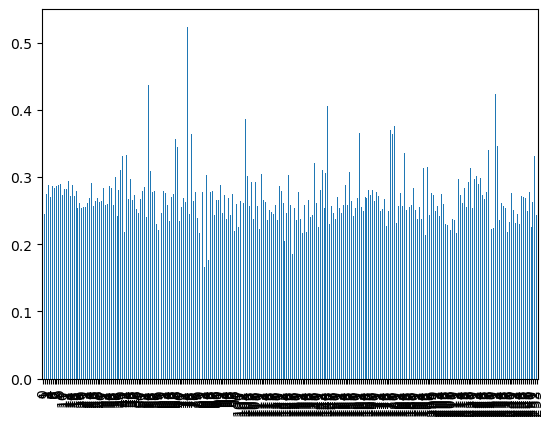

In [368]:
autograde(holdout)